In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from IPython.display import Image
import matplotlib.pyplot as plt
import os

In [2]:
import analysis as an

In [3]:
scenario_list = ['lwr_lwr', 'lwr_msr', 'lwr_sfr']

In [4]:
# get isotopics for input and output recipe
def get_element_content(cur, commodity, z):
    
    query = cur.execute('SELECT * FROM transactions '
                        'INNER JOIN resources ON '
                        'resources.resourceid = transactions.resourceid '
                        'WHERE commodity = "%s"' %commodity).fetchall()
    for i in query:
        qualid = i['qualid']
        break
    query = cur.execute('SELECT NucId, MassFrac FROM compositions '
                        'WHERE qualid = %i' %qualid).fetchall()
    el_content = 0
    for row in query:
        if row['NucId'] // 1e7 == z:
            el_content += row['MassFrac']
    return el_content


In [5]:
metric_dict = {'lwr_lwr':{}, 'lwr_sfr':{}, 'lwr_msr':{}}

## LWR - LWR

In [6]:
cur = an.get_cursor('./output/various_fleets/lwr_lwr.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

# lwr waste
storage = an.get_agent_ids(cur, 'storage')
sink = an.get_agent_ids(cur, 'sink')

lwr_waste = an.facility_commodity_flux(cur, storage, ['cooled_uox'],
                                       True, True)
print('TOTAL LWR WASTE AT 2120:')
metric_dict['lwr_lwr']['lwr waste'] = lwr_waste['cooled_uox']
val = lwr_waste['cooled_uox'][-1]
print("{:,}".format(val))

# SWU
swu = an.get_swu_dict(cur, True)
key = list(swu.keys())[0]
metric_dict['lwr_lwr']['swu'] = swu[key]
print('TOTAL SWU AT 2120:')
val = swu[key][-1]
print("{:,}\n".format(val))

# pu accumulation
pu_in_uox_waste = get_element_content(cur, 'uox_waste', 94)
pu_in_2013 = get_element_content(cur, 'pre_2013_unf', 94)
print(pu_in_uox_waste)
print(pu_in_2013)
pre_13 =an.facility_commodity_flux(cur, sink, ['pre_2013_unf'],
                                   False, True)
print('TOTAL PU IN LWR WASTE AT 2120:')
################# APPROXIMATED HIGHER BURNUP #############
################# THUS MORE PU (~1.1 PERCENT) ############

val = pu_in_2013 * lwr_waste['cooled_uox'][-1]
val += pu_in_2013 * pre_13['pre_2013_unf'][-1] 
metric_dict['lwr_lwr']['pu'] = val
print("{:,}\n".format(val))

# u utilization - average is automatically printed
u_util = an.u_util_calc(cur)
metric_dict['lwr_lwr']['u util'] = u_util
print('\n')

# depleted uranium discharge
dep_u = an.facility_commodity_flux(cur, sink, ['tailings'],
                                   False, True)
print('TOTAL TAILINGS AT 2120:')
val = dep_u['tailings'][-1]
metric_dict['lwr_lwr']['tailings'] = val
print("{:,}\n".format(val))

# natl u demand
natu = an.nat_u_timeseries(cur, True)
val = natu[-1]
print('TOTAL NATURAL URANIUM USAGE AT 2120:')
print("{:,}\n".format(val))
metric_dict['lwr_lwr']['nat u'] = val

# final waste activity


TOTAL LWR WASTE AT 2120:
429,636.84500000003
TOTAL SWU AT 2120:
2,001,340,657.4377377

0.01260317036747676
0.011832208214858222
TOTAL PU IN LWR WASTE AT 2120:
5,888.995039382845

The Average Fuel Utilization Factor is: 
0.14162205591196908


TOTAL TAILINGS AT 2120:
3,194,080.2040944602

TOTAL NATURAL URANIUM USAGE AT 2120:
3,728,669.1193362



## LWR - SFR

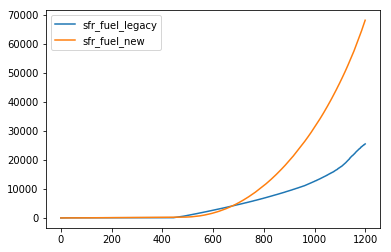

0.01260317036747676
0.937
0.05
0.08372314625797583
TOTAL LWR REPROCESSED AT 2120:
303,350.81965821655
TOTAL SFR REPROCESSED AT 2120:
70,112.06899891113
TOTAL REP WASTE AT 2120:
21,037.54399015596
TOTAL REP U AT 2120:
79,541.73618926718
TOTAL SFr WASTE AT 2120:
68,324.11200000001
TOTAL LWR WASTE AT 2120:
86,800.58534178347


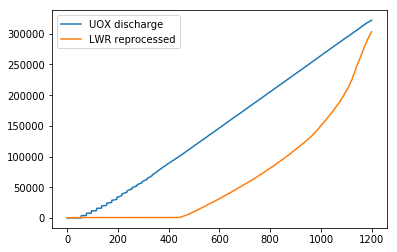

In [7]:
cur = an.get_cursor('./output/various_fleets/lwr_sfr.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

# sfr fuel
reactor = an.get_agent_ids(cur, 'mixer')
fuel = an.facility_commodity_flux(cur, reactor, ['sfr_fuel_legacy', 'sfr_fuel_new'],
                                  True, True)
for key, val in fuel.items():
    plt.plot(val, label=key)
plt.legend()
plt.show()
plt.close()

# pu comp of various fuel
pu_in_sfr = get_element_content(cur, 'sfr_fuel_legacy', 94)
pu_in_sfr_out = get_element_content(cur, 'cooled_sfr', 94)
u_in_sfr_out = get_element_content(cur, 'cooled_sfr', 92)
pu_in_blanket = get_element_content(cur, 'cooled_blanket', 94)
pu_in_blanket
pu_in_legacy = get_element_content(cur, 'pre_2013_unf', 94)
sfr_rep_waste = 1 - pu_in_sfr_out - u_in_sfr_out

#pu_in_uox = get_element_content(cur, 'cooled_uox', 94)
pu_in_uox = get_element_content(cur, 'uox_waste', 94)
u_in_uox = 0.937
print(pu_in_uox)
print(u_in_uox)
uox_rep_waste = 0.05

print(uox_rep_waste)
print(sfr_rep_waste)
# lwr waste
pu_from_legacy = pu_in_sfr * np.array(fuel['sfr_fuel_legacy'])
fuel_reprocessed = pu_from_legacy / pu_in_uox
print('TOTAL LWR REPROCESSED AT 2120:')
val = fuel_reprocessed[-1]
print("{:,}".format(val))
metric_dict['lwr_sfr']['lwr rep'] = fuel_reprocessed

# total lwr unf outputted
storage = an.get_agent_ids(cur, 'storage')
lwr_waste = an.facility_commodity_flux(cur, storage, ['cooled_uox'], True, True)
outstanding = np.array(lwr_waste['cooled_uox']) - np.array(fuel_reprocessed)
metric_dict['lwr_sfr']['lwr wate'] = outstanding

pu_from_sfr = pu_in_sfr * np.array(fuel['sfr_fuel_new'])
sfr_fuel_reprocessed = pu_from_sfr / pu_in_sfr_out
print('TOTAL SFR REPROCESSED AT 2120:')
val = sfr_fuel_reprocessed[-1]
print("{:,}".format(val))
metric_dict['lwr_sfr']['sfr rep'] = sfr_fuel_reprocessed

print('TOTAL REP WASTE AT 2120:')
val = sfr_fuel_reprocessed[-1] * sfr_rep_waste + fuel_reprocessed[-1] * uox_rep_waste
print("{:,}".format(val))
metric_dict['lwr_sfr']['raffinate'] = sfr_fuel_reprocessed * sfr_rep_waste + fuel_reprocessed * uox_rep_waste


print('TOTAL REP U AT 2120:')
val = pu_from_legacy[-1] * 0.85/0.15 + pu_from_sfr[-1] * 0.85/0.15
print("{:,}".format(val))


storage = an.get_agent_ids(cur, 'storage')
sep = an.get_agent_ids(cur, 'separations')
pre13 = an.facility_commodity_flux(cur, sep, ['pre_2013_unf'],
                                   False, True)
lwr_waste = an.facility_commodity_flux(cur, storage, ['cooled_uox'],
                                       True, True)
sfr_waste = an.facility_commodity_flux(cur, storage, ['cooled_sfr'],
                                       True, True)
total_sfr_waste = sfr_waste['cooled_sfr'][-1]
print('TOTAL SFr WASTE AT 2120:')
val = total_sfr_waste
print("{:,}".format(val))

total_lwr_generated = lwr_waste['cooled_uox'][-1]
total_lwr_generated += pre13['pre_2013_unf'][-1]
unreprocessed_lwr_fuel = total_lwr_generated - fuel_reprocessed[-1]
print('TOTAL LWR WASTE AT 2120:')
val = unreprocessed_lwr_fuel
print("{:,}".format(val))

plt.plot(lwr_waste['cooled_uox'], label='UOX discharge')
plt.plot(fuel_reprocessed, label='LWR reprocessed')
plt.legend()
plt.show()
plt.close()



In [8]:

def twosum(timeseries_list):
    """Aggregates timeseries list of length 2x to x
       by summing up the two adjacent values"""
    result = []
    list_indx = 0
    total = 0
    timeseries_list = timeseries_list[1:]
    while True:
        total += timeseries_list[list_indx]
        list_indx += 1
        if list_indx == len(timeseries_list) - 1:
            break
        if list_indx%12 == 0:
            result.append(total)
            total = 0
    return result


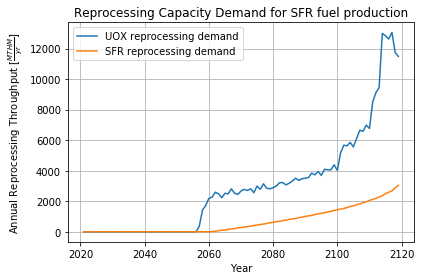

In [9]:
fuel_no_cum = an.facility_commodity_flux(cur, reactor, ['sfr_fuel_legacy', 'sfr_fuel_new'],
                                  True, False)
uox_rep_fuel = np.array(fuel_no_cum['sfr_fuel_legacy']) * pu_in_sfr / pu_in_uox
for i in range(100):
    uox_rep_fuel[i] = 0
sfr_rep_fuel = np.array(fuel_no_cum['sfr_fuel_new']) * pu_in_sfr / pu_in_sfr_out
years = np.array(range(1, 100)) + 2020
z = twosum(uox_rep_fuel)
k = twosum(sfr_rep_fuel)
plt.plot(years, z, label='UOX reprocessing demand')
plt.plot(years, k, label='SFR reprocessing demand')
plt.grid()
plt.legend()
plt.xlabel('Year')
plt.ylabel('Annual Reprocessing Throughput [$\\frac{MTHM}{yr}$]')
plt.title('Reprocessing Capacity Demand for SFR fuel production')
plt.tight_layout()
plt.savefig('./output/images/rep.png')
plt.show()
plt.close()


# SWU
swu = an.get_swu_dict(cur, True)
key = list(swu.keys())[0]
print('TOTAL SWU AT 2120:')
val = swu[key][-1]
print("{:,}\n".format(val))

In [10]:

# pu accumulation
pu_in_uox = get_element_content(cur, 'uox_waste', 94)
print(pu_in_uox)
sep = an.get_agent_ids(cur, 'separations') 
pre13 = an.facility_commodity_flux(cur, sep, ['pre_2013_unf', 'cooled_uox'],
                                   False, True)
pu_from_13 = np.array(pre13['pre_2013_unf']) * pu_in_legacy
print('Plutonium From UOX inventory pre-2013:')
print(pu_from_13[-1])
pu_from_lwr = np.array(pre13['cooled_uox']) * pu_in_uox
print('Plutonium from LWR operation after 2020:')
print(pu_from_lwr[-1])
sfr_waste = an.facility_commodity_flux(cur, storage, ['sfr_used'],
                                       False, True)
pu_from_sfr = np.array(sfr_waste['sfr_used']) * pu_in_sfr_out
blanket_waste = an.facility_commodity_flux(cur, storage, ['blanket_used'],
                                           False, True)
pu_from_blanket = np.array(blanket_waste['blanket_used']) * pu_in_blanket

# pu generated from lwr + driver + blanket
pu_generation = pu_from_lwr + pu_from_sfr + pu_from_blanket + pu_from_13

total_sfr_fuel = np.array(fuel['sfr_fuel_legacy']) + np.array(fuel['sfr_fuel_new'])
pu_usage = total_sfr_fuel * pu_in_sfr


0.01260317036747676
Plutonium From UOX inventory pre-2013:
805.4424325680753
Plutonium from LWR operation after 2020:
4059.221234975435


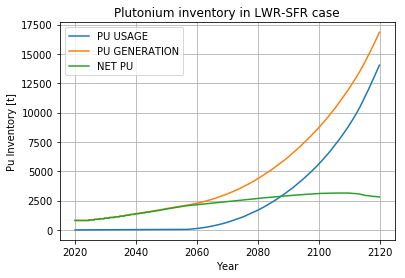

TOTAL PU IN 2120:
2,806.250070236287



In [11]:
years = 2020 + (timestep/12)
net_pu = pu_generation - pu_usage
plt.plot(years, pu_usage,  label='PU USAGE')
plt.plot(years, pu_generation, label='PU GENERATION')
plt.plot(years, net_pu, label='NET PU')
plt.title('Plutonium inventory in LWR-SFR case')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Pu Inventory [t]')
plt.grid()
plt.savefig('./output/images/lwr_sfr_pu.png')
plt.show()
plt.close()

print('TOTAL PU IN 2120:')
val = pu_generation[-1] - pu_usage[-1]
print("{:,}\n".format(val))

metric_dict['lwr_sfr']['pu'] = net_pu

In [12]:

# u utilization - average is automatically printed
u_util = an.u_util_calc(cur)
metric_dict['lwr_sfr']['u util'] = u_util
print('\n')

# depleted uranium discharge
sink = an.get_agent_ids(cur, 'sink')
dep_u = an.facility_commodity_flux(cur, sink, ['tailings'],
                                   False, True)
print('TOTAL TAILINGS AT 2120:')
# used for blanket
sou = an.get_prototype_id(cur, 'blanket_source')
depu = an.facility_commodity_flux(cur, sou, ['blanket'], True, True)
val = dep_u['tailings'][-1]
val -= depu['blanket'][-1]
print("{:,}\n".format(val))
metric_dict['lwr_sfr']['tailings'] = np.array(dep_u['tailings']) - np.array(depu['blanket']) 

# natl u demand
natu = an.nat_u_timeseries(cur, True)
val = natu[-1]
print('TOTAL NATURAL URANIUM USAGE AT 2120:')
print("{:,}\n".format(val))
metric_dict['lwr_sfr']['nat u'] = natu

# final waste activity

../../scripts/analysis.py:952: RuntimeWarning: invalid value encountered in true_divide
  u_util_timeseries = np.nan_to_num(fuel_timeseries / u_supply_timeseries)


The Average Fuel Utilization Factor is: 
0.1519295110585538


TOTAL TAILINGS AT 2120:
2,035,928.4119722855

TOTAL NATURAL URANIUM USAGE AT 2120:
2,387,253.2641985063



## LWR - MSR

In [13]:
cur = an.get_cursor('./output/various_fleets/lwr_msr(1).sqlite')
cur = an.get_cursor('/Users/13b/Downloads/lwr_pref.sqlite')
z = cur.execute('SELECT distinct(commodity) from transactions').fetchall()
for row in z:
    print(row['commodity'])

natl_u
na
cl
na2
cl2
depu_msr
pre_2013_unf
uox
lwr_pu
lwr_u
reprocess_waste
tailings
fuel_from_lwr
fill
waste
pu
uox_waste
cooled_uox
output_fuel
rep_pu
fuel_from_msr


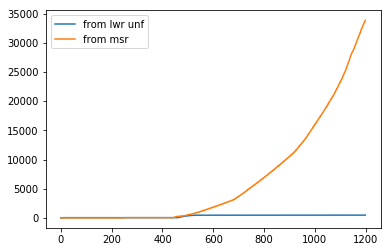

In [14]:
# total fuel usage
cur = an.get_cursor('./output/various_fleets/lwr_msr.sqlite')
mix = an.get_agent_ids(cur, 'mixer')
fuel = an.facility_commodity_flux(cur, mix, ['fuel_from_lwr', 'fuel_from_msr'], True, True )
total_fuel = [x+y for x,y in zip(fuel['fuel_from_lwr'], fuel['fuel_from_msr'])]
pu_in_msr = get_element_content(cur, 'fuel_from_lwr', 94)
pu_from_lwr = np.array(fuel['fuel_from_lwr']) * pu_in_msr
pu_in_lwr = get_element_content(cur, 'uox_waste', 94)
lwr_reprocessed = pu_from_lwr / pu_in_lwr

#plt.plot(total_fuel, label='total fuel')
plt.plot(fuel['fuel_from_lwr'], label='from lwr unf')
plt.plot(fuel['fuel_from_msr'], label='from msr')
plt.legend()
plt.show()
plt.close()



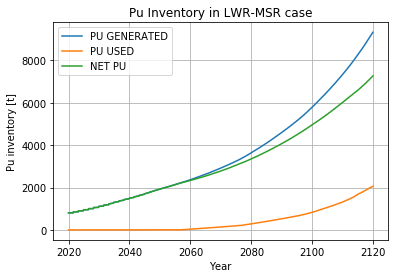

TOTAL PU Inventory AT 2120:
7,268.112951555036



In [15]:
# pu comp of various fuel
pu_in_msr = get_element_content(cur, 'fuel_from_lwr', 94)
pu_in_msr_out = get_element_content(cur, 'output_fuel', 94)
pu_in_uox = get_element_content(cur, 'uox_waste', 94)
u_in_uox = 0.937
rep_waste = 0.05
pu_in_legacy = get_element_content(cur, 'pre_2013_unf', 94)

stor = an.get_agent_ids(cur, 'storage')
rep = an.get_agent_ids(cur, 'separations')
mix = an.get_agent_ids(cur, 'mixer')

# pu generated
pu_gen_lwr = an.facility_commodity_flux(cur, stor, ['uox_waste'], False, True)
pu_gen_lwr = np.array(pu_gen_lwr['uox_waste']) * pu_in_uox
pu_gen_legacy = an.facility_commodity_flux(cur, rep, ['pre_2013_unf'], False, True)
pu_gen_legacy = np.array(pu_gen_legacy['pre_2013_unf']) * pu_in_legacy
pu_gen_msr = an.facility_commodity_flux(cur, mix, ['pu'], False, True)
pu_gen_msr = np.array(pu_gen_msr['pu'])
pu_gen_msr_out = an.facility_commodity_flux(cur, rep, ['output_fuel'], False, True)
pu_gen_msr_out = np.array(pu_gen_msr_out['output_fuel']) * pu_in_msr_out

pu_gen_tot = pu_gen_lwr + pu_gen_legacy + pu_gen_msr + pu_gen_msr_out

# pu used
pu_used = np.array(total_fuel) * pu_in_msr

net_pu = pu_gen_tot - pu_used
plt.plot(years, pu_gen_tot, label='PU GENERATED')
plt.plot(years, pu_used, label='PU USED')
plt.plot(years, net_pu, label='NET PU')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Pu inventory [t]')
plt.title('Pu Inventory in LWR-MSR case')
plt.legend()
plt.savefig('./output/images/lwr_msr_pu.png')
plt.show()
plt.close()


print('TOTAL PU Inventory AT 2120:')
val = net_pu[-1]
print("{:,}\n".format(val))
metric_dict['lwr_msr']['pu'] = net_pu


2266.2801117436825

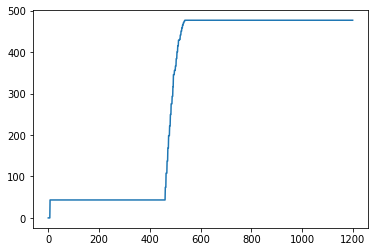

In [16]:
# msr fuel from lwr mixer
mix = an.get_agent_ids(cur, 'mixer')
fuel = an.facility_commodity_flux(cur, mix, ['fuel_from_lwr'], True, True)
plt.plot(fuel['fuel_from_lwr'])
np.array(fuel['fuel_from_lwr'])[-1] * pu_in_msr / pu_in_uox

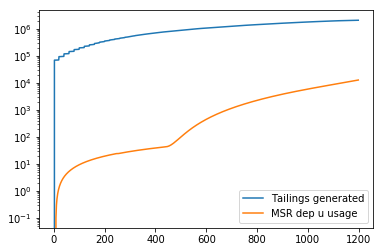

TOTAL TAILINGS AT 2120:
2,035,035.8279722903

TOTAL NATURAL URANIUM USAGE AT 2120:
2,387,253.2641985063



In [17]:
# depleted uranium discharge
sink = an.get_agent_ids(cur, 'sink')
dep_u = an.facility_commodity_flux(cur, sink, ['tailings'],
                                   False, True)


# dep u usage
fill_source = an.get_prototype_id(cur, 'fill_source')
fill = an.facility_commodity_flux(cur, fill_source, ['fill'], True, True)

plt.semilogy(dep_u['tailings'], label='Tailings generated')
plt.semilogy(fill['fill'], label='MSR dep u usage')
plt.legend()
plt.show()
plt.close()
print('TOTAL TAILINGS AT 2120:')
val = np.array(dep_u['tailings']) - np.array(fill['fill'])

metric_dict['lwr_msr']['tailings'] = val
val = val[-1]
print("{:,}\n".format(val))

# natl u demand
natu = an.nat_u_timeseries(cur, True)
val = natu[-1]
print('TOTAL NATURAL URANIUM USAGE AT 2120:')
print("{:,}\n".format(val))
 
metric_dict['lwr_msr']['nat u'] = natu

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0725, 0.145, 0.2175, 0.29, 0.3625, 0.435, 0.5075000000000001, 0.58, 0.6525, 0.725, 0.7975, 0.87, 0.9425, 1.0150000000000001, 1.0875000000000001, 1.16, 1.2325, 1.305, 1.3775, 1.45, 1.5225, 1.595, 1.6675, 1.74, 1.8125, 1.885, 1.9575, 2.0300000000000002, 2.1025, 2.1750000000000003, 2.2475, 2.32, 2.3925, 2.465, 2.5375, 2.61, 2.6825, 2.755, 2.8275, 2.9, 2.9725, 3.045, 3.1175, 3.19, 3.2625, 3.335, 3.4075, 3.48, 3.5525, 3.625, 3.6975000000000002, 3.77, 3.8425000000000002, 3.915, 3.9875000000000003, 4.0600000000000005, 4.1325, 4.205, 4.2775, 4.3500000000000005, 4.4225, 4.495, 4.5675, 4.64, 4.7125, 4.785, 4.8575, 4.93, 5.0025, 5.075, 5.1475, 5.22, 5.2925, 5.365, 5.4375, 5.51, 5.5825000000000005, 5.655, 5.7275, 5.8, 5.8725000000000005, 5.945, 6.0175, 6.09, 6.1625000000000005, 6.235, 6.3075, 6.38, 6.452500000000001, 6.525, 6.5975, 6.67, 6.7425, 6.815, 6.8875, 6.96, 7.0325, 7.105, 7.1775, 7.25, 7.3225, 7.3950000000000005, 7.4675, 7.54, 7.6125, 7.685000000

9868.507727221313

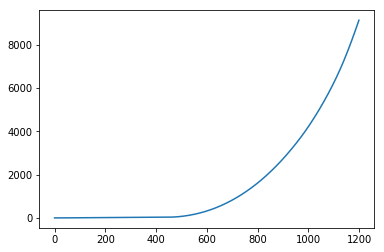

In [19]:
# waste
sink = an.get_agent_ids(cur, 'sink')
was = an.facility_commodity_flux(cur, sink, ['waste'], False, True)
plt.plot(was['waste'])

lwr_rep_waste = np.array(fuel['fuel_from_lwr'])[-1] * pu_in_msr / 0.05

msr_rep = an.get_prototype_id(cur, 'msr_reprocessing')
msr_rep_waste = an.facility_commodity_flux(cur, msr_rep, ['reprocess_waste'], True, True)

print(was['waste'])
print(lwr_rep_waste)
print(msr_rep_waste['reprocess_waste'][-1])
metric_dict['lwr_msr']['raffinate'] = msr_rep_waste['reprocess_waste'][-1]
was['waste'][-1] + lwr_rep_waste + msr_rep_waste['reprocess_waste'][-1]